## Social network Graph Link Prediction - Facebook Challenge

###Problem statement:

- Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

## Data Overview

Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting
data contains two columns source and destination node edge in graph - Data columns (total 2 columns):
- source_node int64
- destination_node int64

Mapping the problem into supervised learning problem:

- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link.
- Some reference papers and videos :

https://www.cs.cornell.edu/home/kleinber/link-pred.pdf

https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf

https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf

https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:

- No low-latency requirement.
- Probability of prediction is useful to recommend highest probability links.
- We got to support connections which are most likely to connect and we should try not to missing any possible connection.

###Performance metric for supervised learning:

- Both precision and recall is important so F1 score is good choice
- Confusion matrix

###**Importing Libraries:**

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd   #pandas to create small dataframes 
import datetime   #Convert to unix time
import time   #Convert to unix time

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  #Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans  #Clustering
import math
import pickle
import os
!pip3 install xgboost
import xgboost as xgb

import warnings
!pip3 install networkx
import networkx as nx
import pdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####**NetworkX:**

- NetworkX is a Python language software package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks.
-  It is used to study large complex networks represented in form of graphs with nodes and edges.
- Using networkx we can load and store complex networks.
- We can generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms and draw networks. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Reading graph:**

In [ ]:

if not os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('/content/drive/MyDrive/Facebook/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437518 edges


- We are creating a file without header.
- Here DiGraph means directed graph.
- We are using networkx to get some statistics about the data.
- g is a networkx object in which we stored our whole graph.

### Displaying a sub graph

DiGraph with 66 nodes and 50 edges


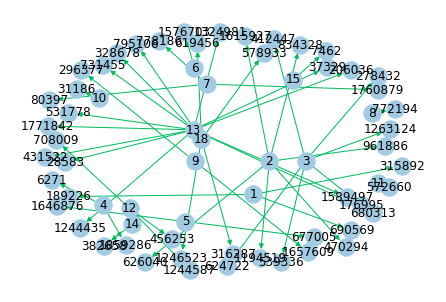

In [ ]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('/content/drive/MyDrive/Facebook/data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# Exploratory Data Analysis

In [ ]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


### No of followers for each person

- The no. of followers is equal to the indegree. 
- We are creating a list with all the indegree for all the users.

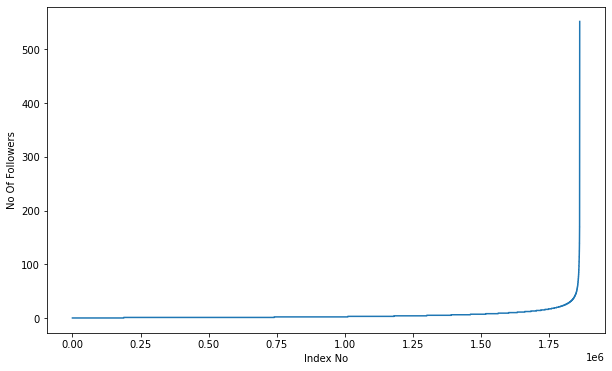

In [ ]:
indegree_dist = list(dict(g.in_degree()).values()) # list of all the in-degrees for all the vertices
indegree_dist.sort() # then sort them
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

- Most of the users have followers less then 40.
- There are thousands of users who does not have any followers at all.
- There is very small sub-set of users wo have more than 40 followers.
- There is 1-2 users who have followers more than 400.

**Let's zoom into this plot to see things more clearly**.

Below

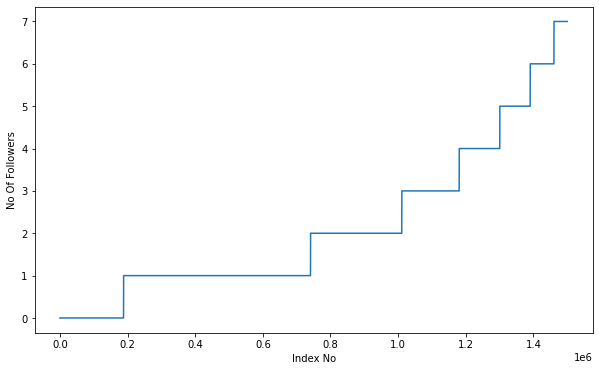

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

Conclusion:
- There are alomst 20,000 users who doesn't have any follower.
- There are roughly 60,000 users who have exacly 1 followers.
- In our 1.5m user they have atmost 7 followers.

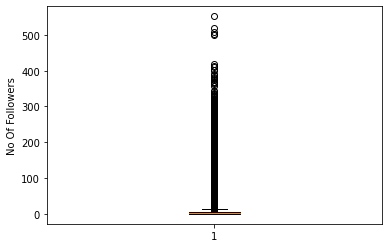

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

- There is no use of plotting boxplot as most of the users have very few followers.
- There are some outliers users who have more than 500 followers.

#####**90-100 percentile:-**

In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


- 99% of users have less than 40 followers only.
- 90% of users have less than 12 followers only.

#####**99-100 percentile:-**

In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


Conclusion:
- There are 0.1 percentile user with followers more than 112.
- Most number of people have very few followers.

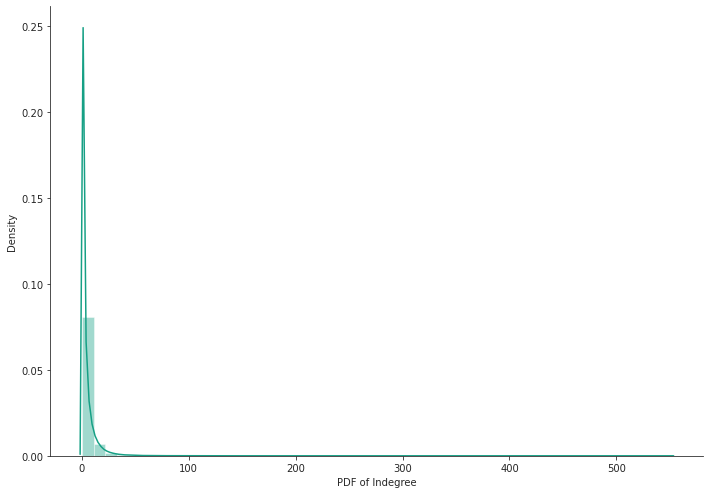

In [ ]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

###**No of people each user is following:-**

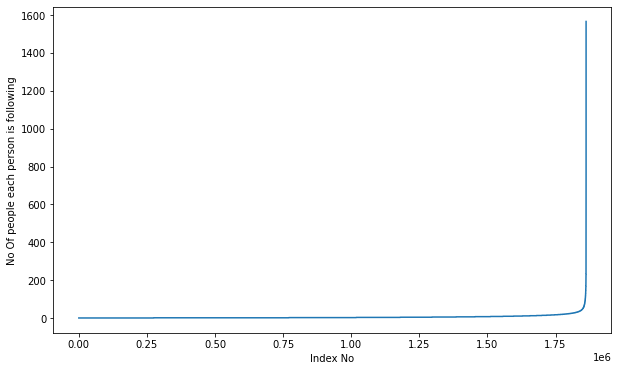

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values()) # list of all the out-going for all the vertices
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

- Most no. of people are following very few no. of people.
- There are these 1-2 guys who are following over 1500 people.

**Now, we try to zoom into the above plot.**

Below

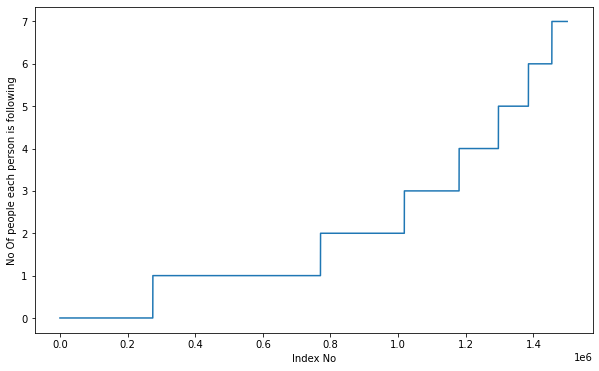

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

- No. of people who does not follow a single person are slightely less than 30,000.
- Over 1.4m users only follow people less than 7.

#####**90-100 percentile:-**

In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


- 90% of users only follow people less than 12.
- 99% of users only follow people less than 40.

#####**99-100 percentile:-**

In [ ]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


- Most of the users follow very few no. of people.

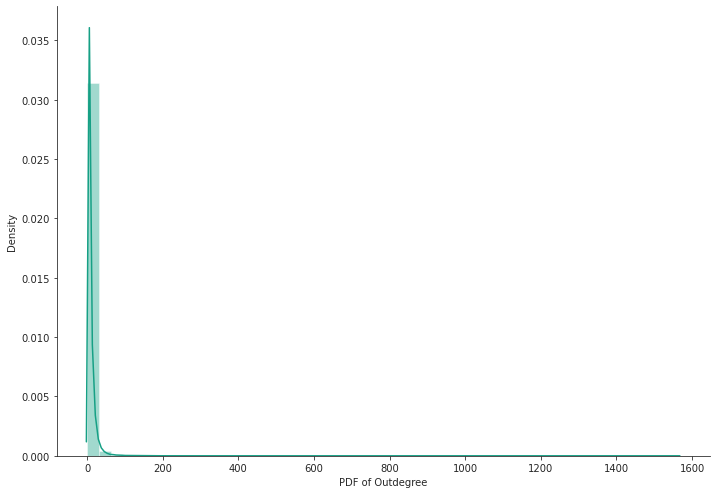

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [ ]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [ ]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [ ]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not following anyone and also not having any followers are',count)

No of persons those are not following anyone and also not having any followers are 0


###**Degree = Indegree + Outdegree:**



In [ ]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

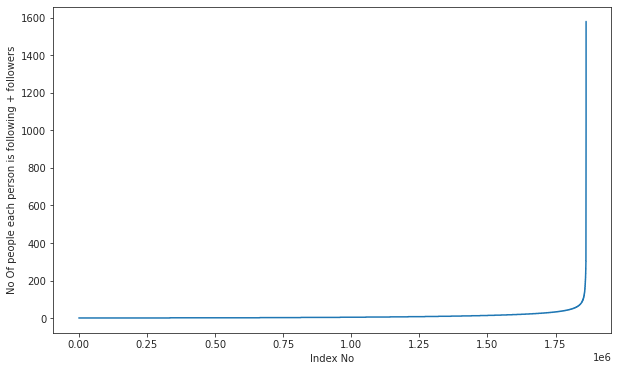

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

- Degree of most of the users are very low.

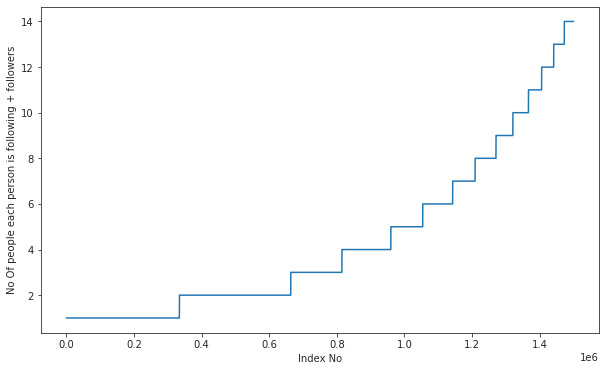

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [ ]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [ ]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195
